In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from pathlib import Path

seed = 42 #424
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.stats as stats

In [2]:
%load_ext autoreload

%autoreload 2


In [3]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("poster")
sns.set_style("ticks")
#sns.set_style("dark")
sns.despine()


<Figure size 720x720 with 0 Axes>

In [4]:
iters = 100
l2 = 1
n_std = 4
epochs = 300#500 is great#500#10000#1000
all_predictions = True
toy = False

showcase = False
num_epochs_per_save = epochs/20
if toy:
    epochs = 2000
    all_predictions = True


def get_fig_path(name):
    return f'housing_figs\\housing_{name}.pdf'

non_linearity = torch.nn.Tanh

In [5]:
from helpers import showcase_code

# Kaggle housing data regression with uncertainty estimates

This is a follow up to the notebook about the toy problem, showing how the presented techiques can be used for real world datasets as well.

## The Data

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The dataset has been stripped of non-numerical variables for ease of use, extreme outliers are removed and mean / std normalisation has been done.

This leaves us with 37 predictors and one target variable.

The dataset has been split in train (0.8) and test set (0.2). As we can see, sorting the dataset by ascending target variable is very beneficial for visualisation purposes, the dataset presented to the models are shuffled randomly.


In [6]:
from data_loaders import get_X_y, generate_y
showcase_code('data_loaders.py')

C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\models\data_loaders.py:142: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)


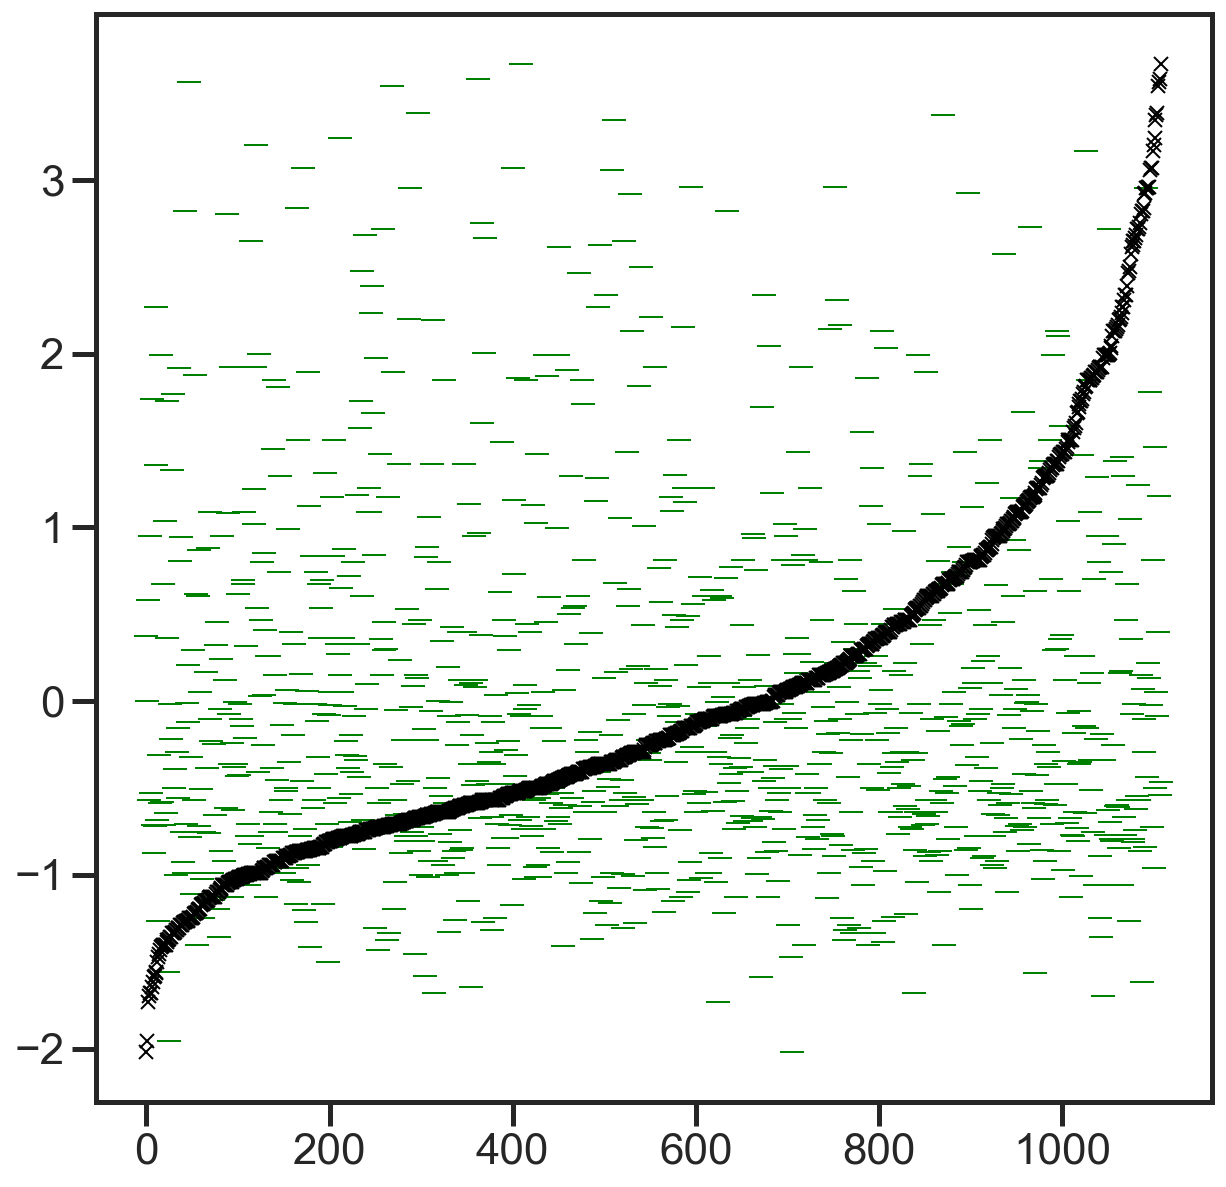

In [7]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed,plot=True,fname=get_fig_path('data'))

$$p(y_{*}|D) = p(y_{*}|f_{*})p(f_{*}|\mu_{*}\\sigma^{2}_{*})$$


In [8]:

showcase_code('measures.py')

In [9]:
from helpers import plot_uncertainty, plot_generating_function
showcase_code('helpers.py')


In [10]:
if toy:
    plot_generating_function(X_test,y_test,generate_y,0.3,N)

In [11]:
from nn_models.base_model import SimpleModel
showcase_code('nn_models/base_model.py')


In [12]:

from nn_models.base_ensemble import VanillaEnsemble
showcase_code('nn_models/base_ensemble.py')
    

In [13]:
vanilla = VanillaEnsemble(toy,output_dims,non_linearity=non_linearity)

C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\models\helpers.py:83: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)


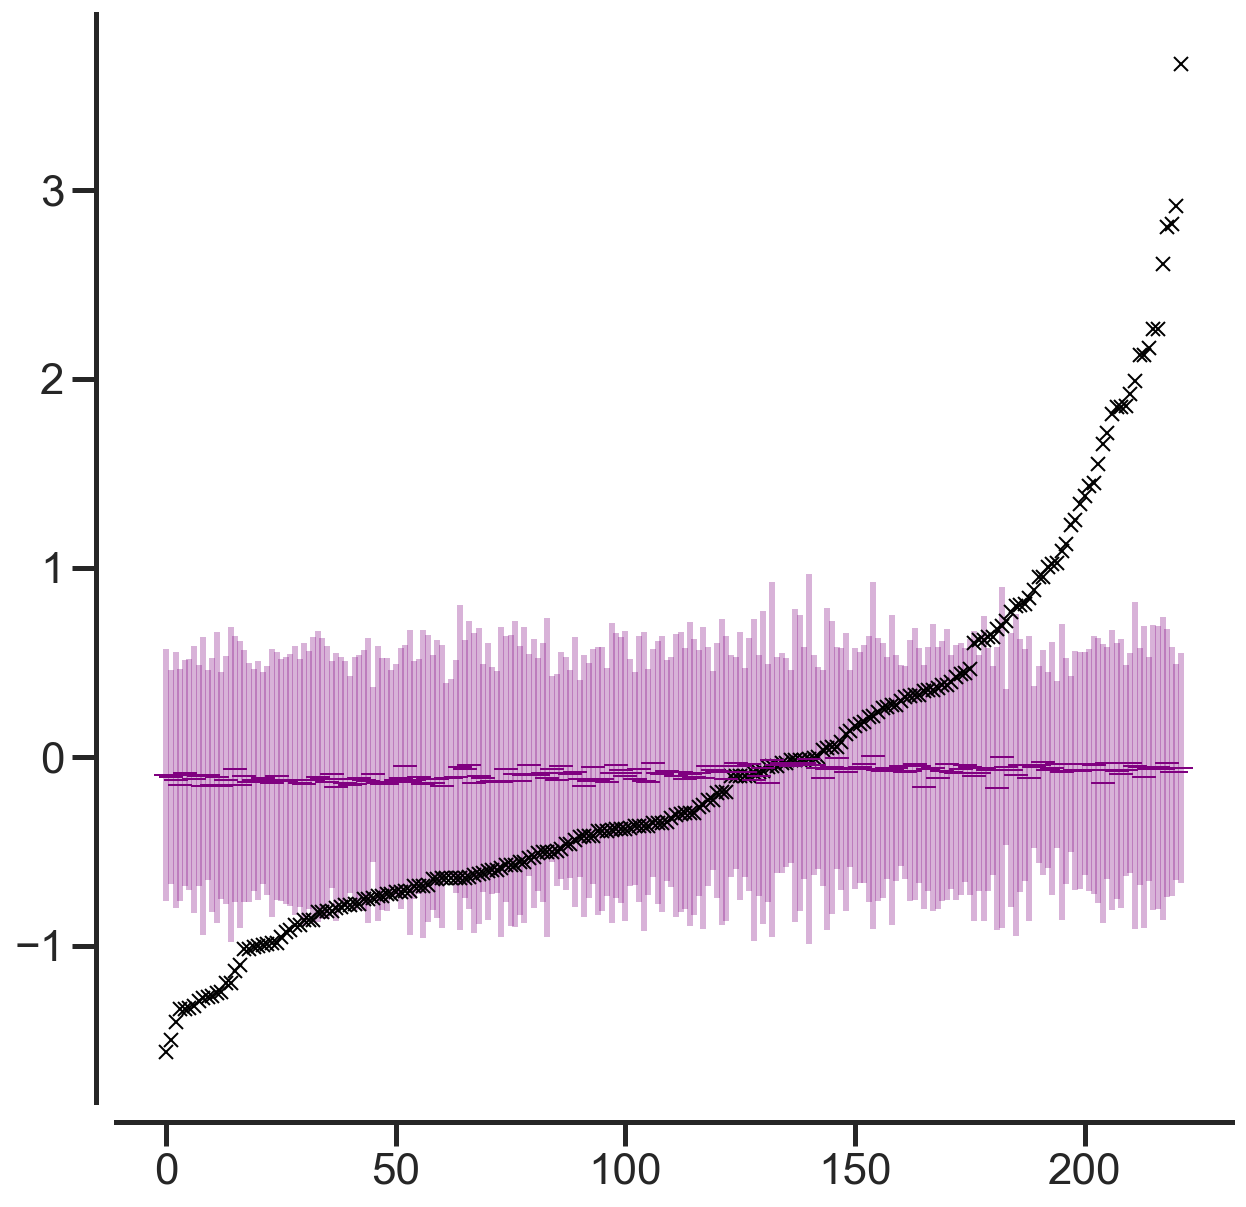

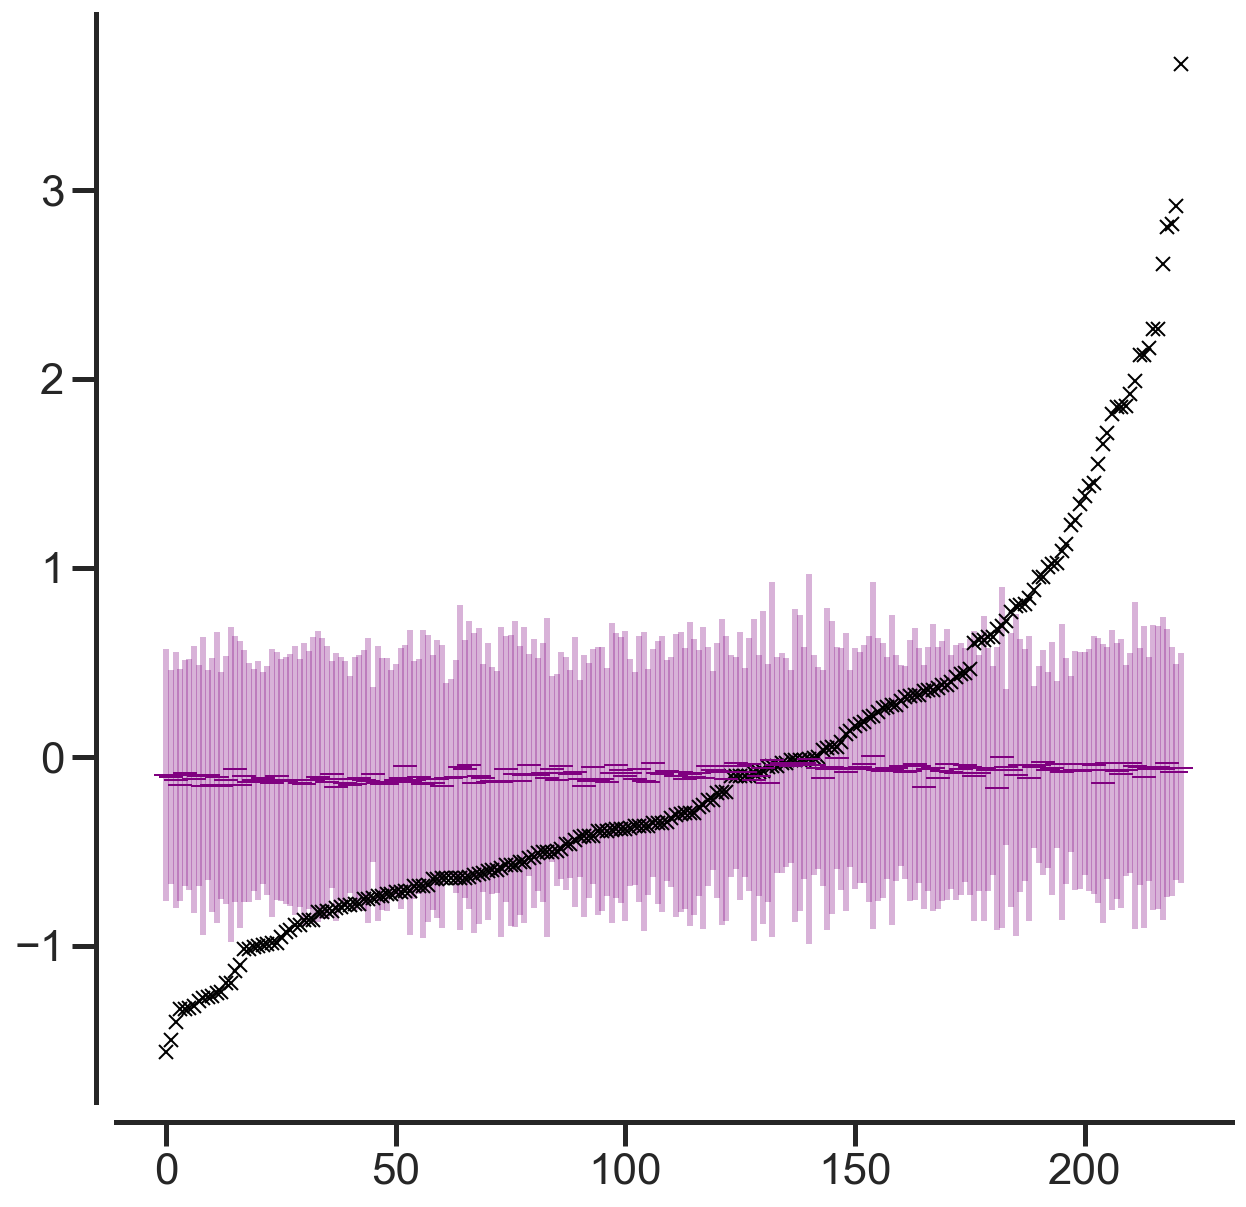

In [14]:
plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('prior_vanilla'))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.42it/s]


final loss: [tensor(0.0698, grad_fn=<MseLossBackward>), tensor(0.0625, grad_fn=<MseLossBackward>), tensor(0.0637, grad_fn=<MseLossBackward>), tensor(0.0614, grad_fn=<MseLossBackward>), tensor(0.0613, grad_fn=<MseLossBackward>), tensor(0.0656, grad_fn=<MseLossBackward>), tensor(0.0619, grad_fn=<MseLossBackward>), tensor(0.0638, grad_fn=<MseLossBackward>), tensor(0.0640, grad_fn=<MseLossBackward>), tensor(0.0627, grad_fn=<MseLossBackward>)]
Wall time: 55.4 s


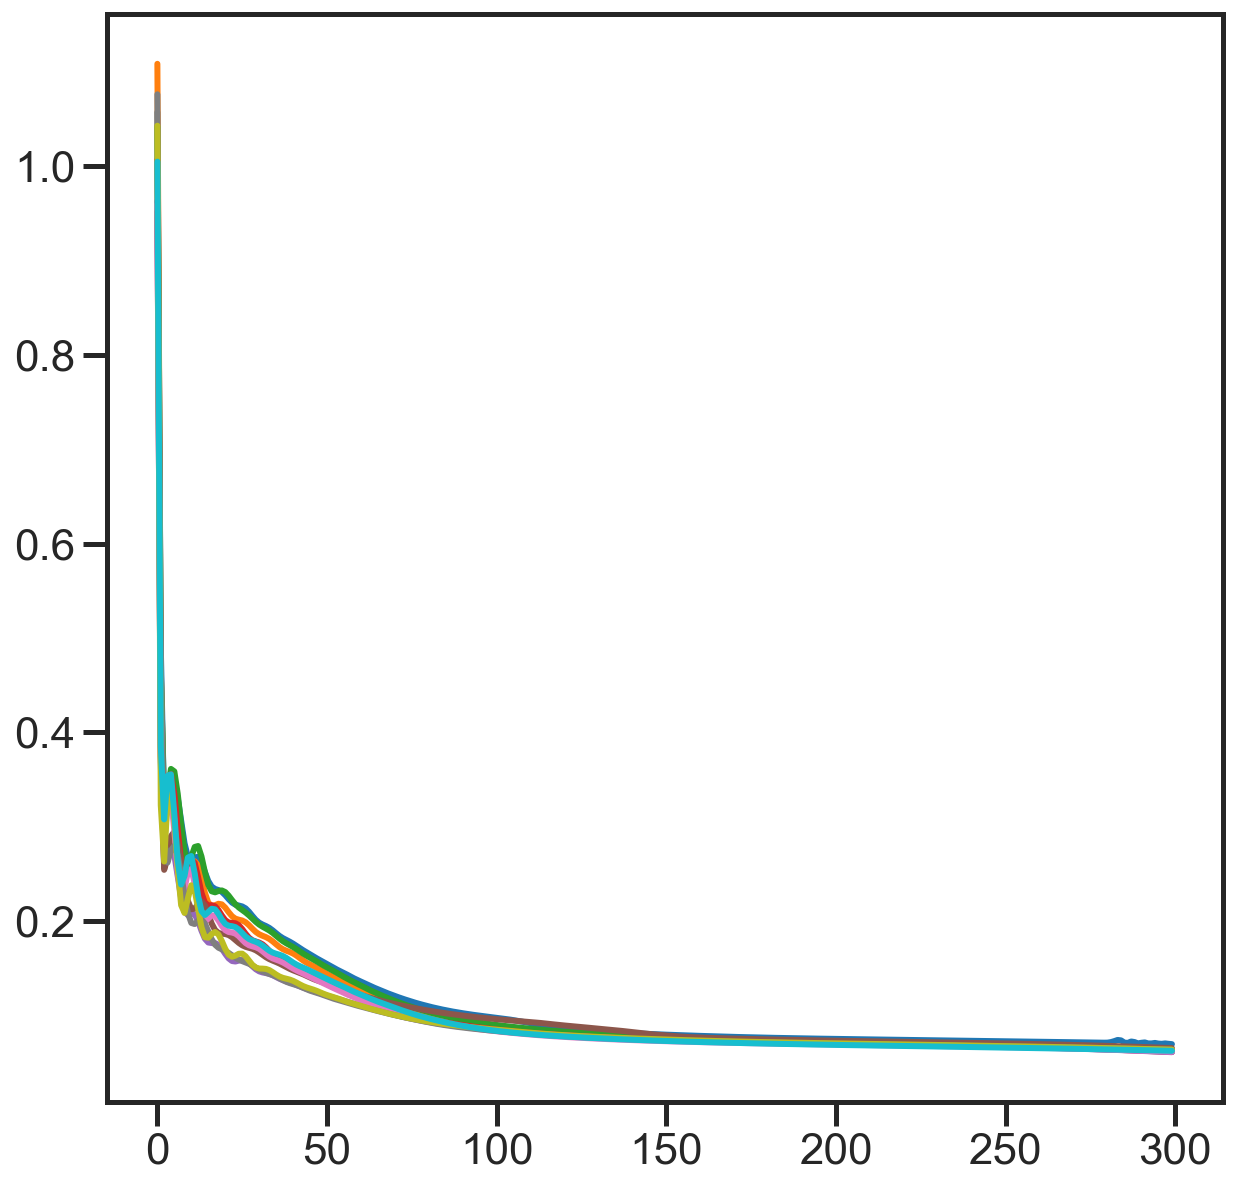

In [15]:
%%time

losses = []

for i in trange(epochs):
    losses.append(vanilla.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [16]:
#plot_uncertainty(vanilla,X_train,y_train,toy,all_predictions=True,fname=get_fig_path('vanilla'))

C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\models\helpers.py:83: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)


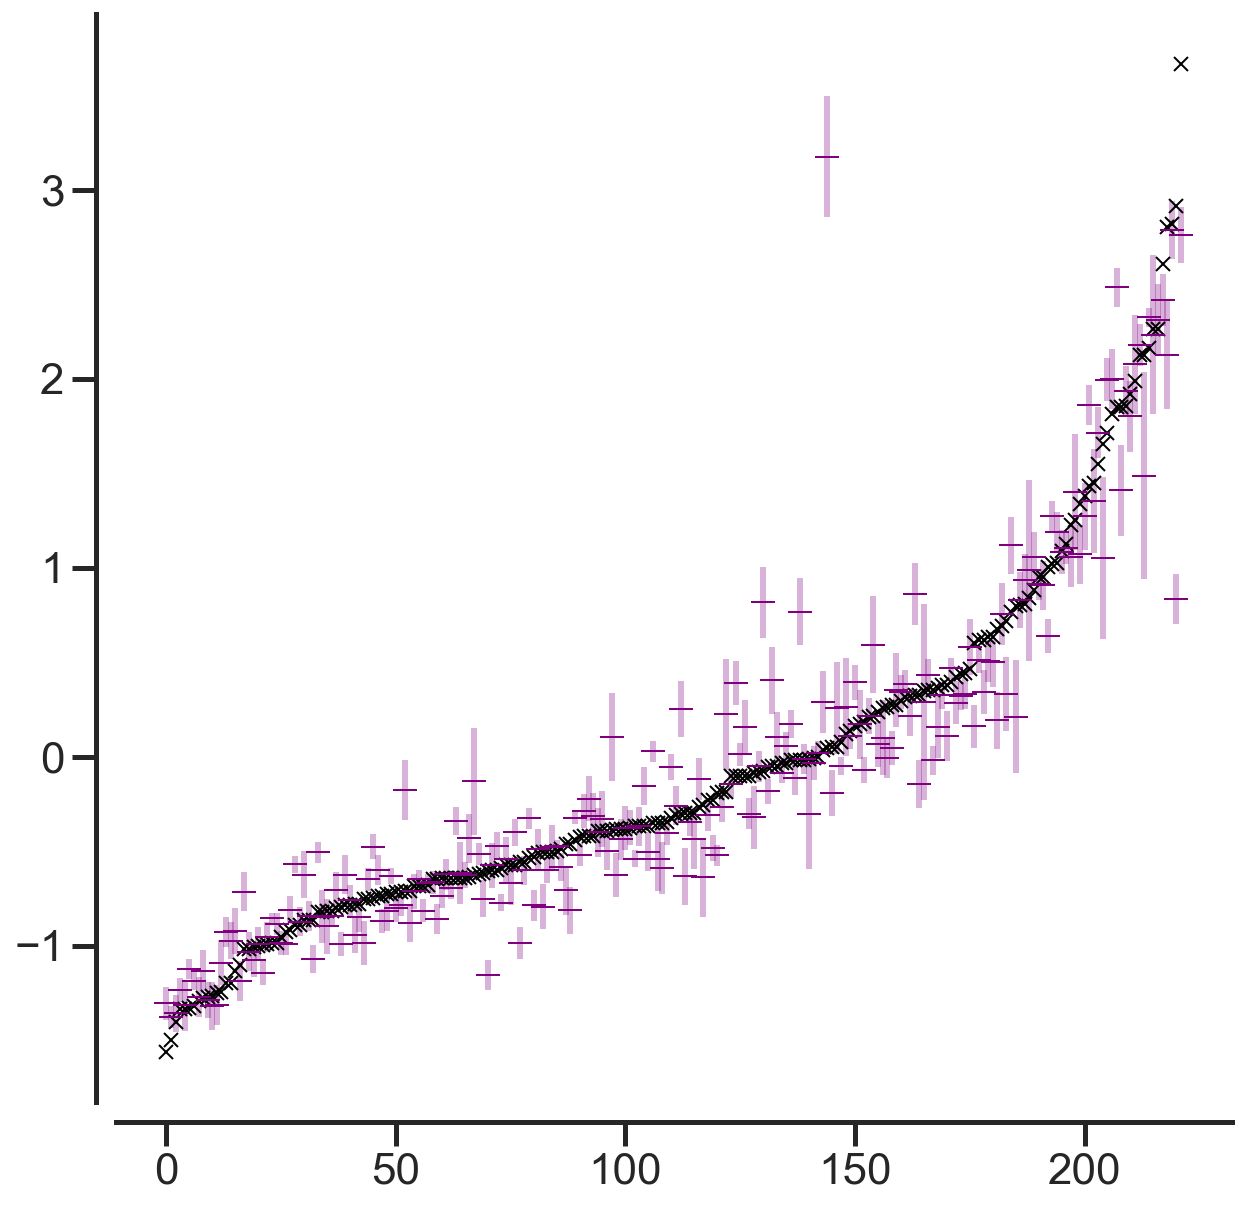

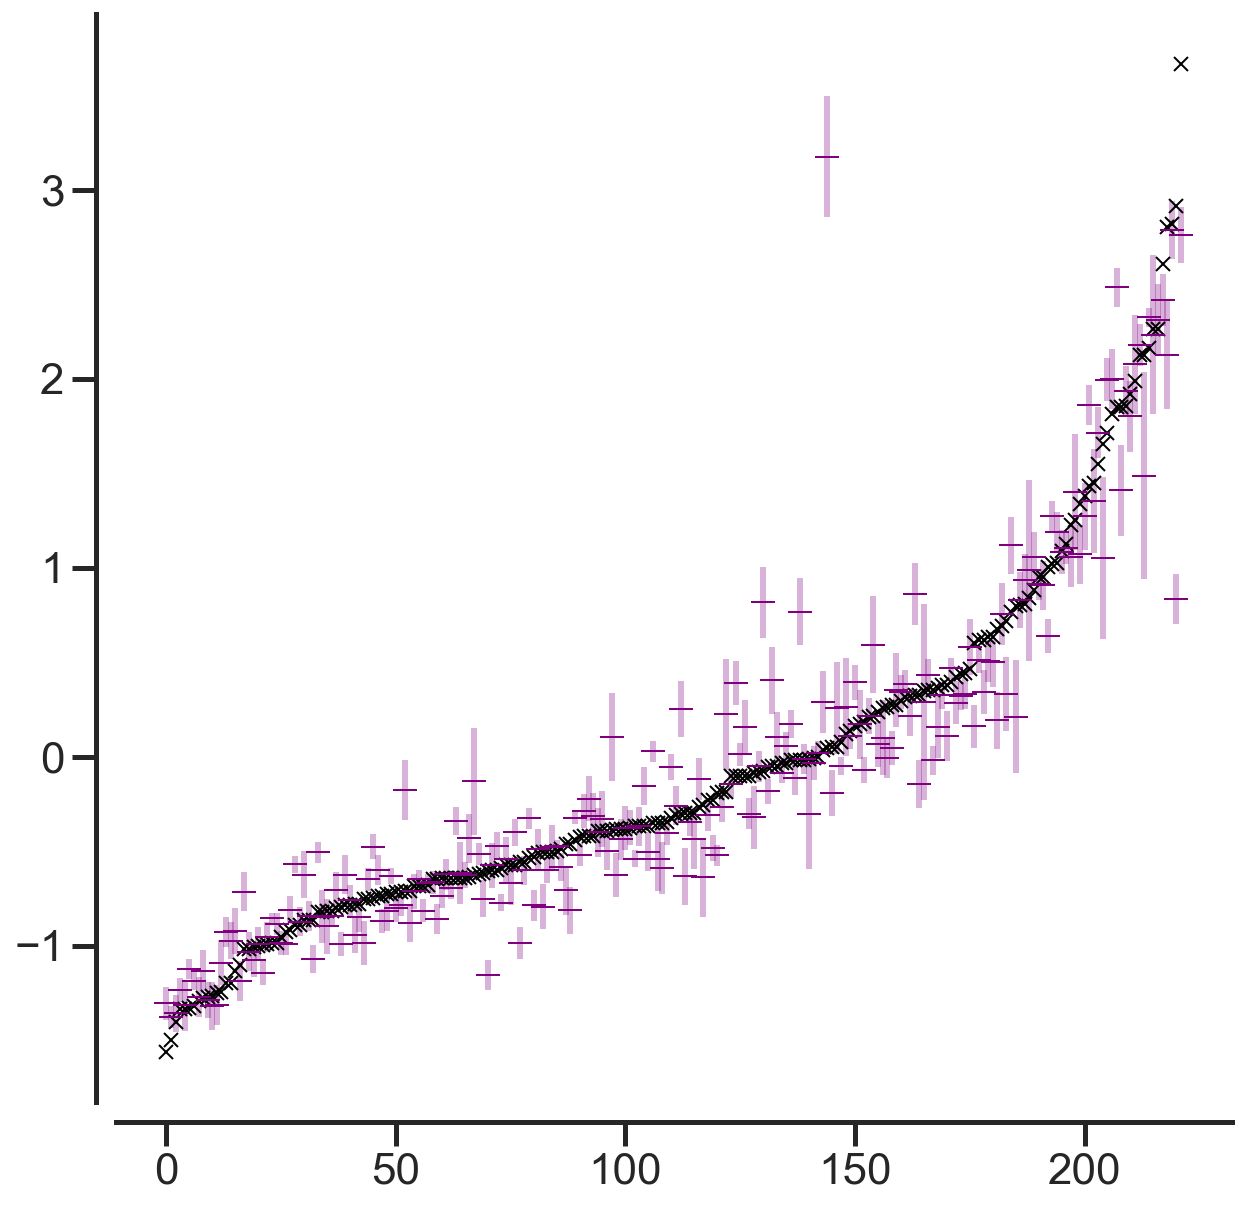

In [17]:
plot_uncertainty(vanilla,X_test,y_test,toy,all_predictions=False,fname=get_fig_path('vanilla'))

In [18]:
from nn_models.ensembles import ShuffleEnsemble

showcase_code('nn_models/ensembles.py','ShuffleEnsemble')

In [19]:
shuffle = ShuffleEnsemble(toy,output_dims,non_linearity=non_linearity)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:07<00:00,  4.46it/s]


final loss: [tensor(0.0684, grad_fn=<MseLossBackward>), tensor(0.0663, grad_fn=<MseLossBackward>), tensor(0.0645, grad_fn=<MseLossBackward>), tensor(0.0655, grad_fn=<MseLossBackward>), tensor(0.0683, grad_fn=<MseLossBackward>), tensor(0.0661, grad_fn=<MseLossBackward>), tensor(0.0649, grad_fn=<MseLossBackward>), tensor(0.0650, grad_fn=<MseLossBackward>), tensor(0.0650, grad_fn=<MseLossBackward>), tensor(0.0619, grad_fn=<MseLossBackward>)]
Wall time: 1min 7s


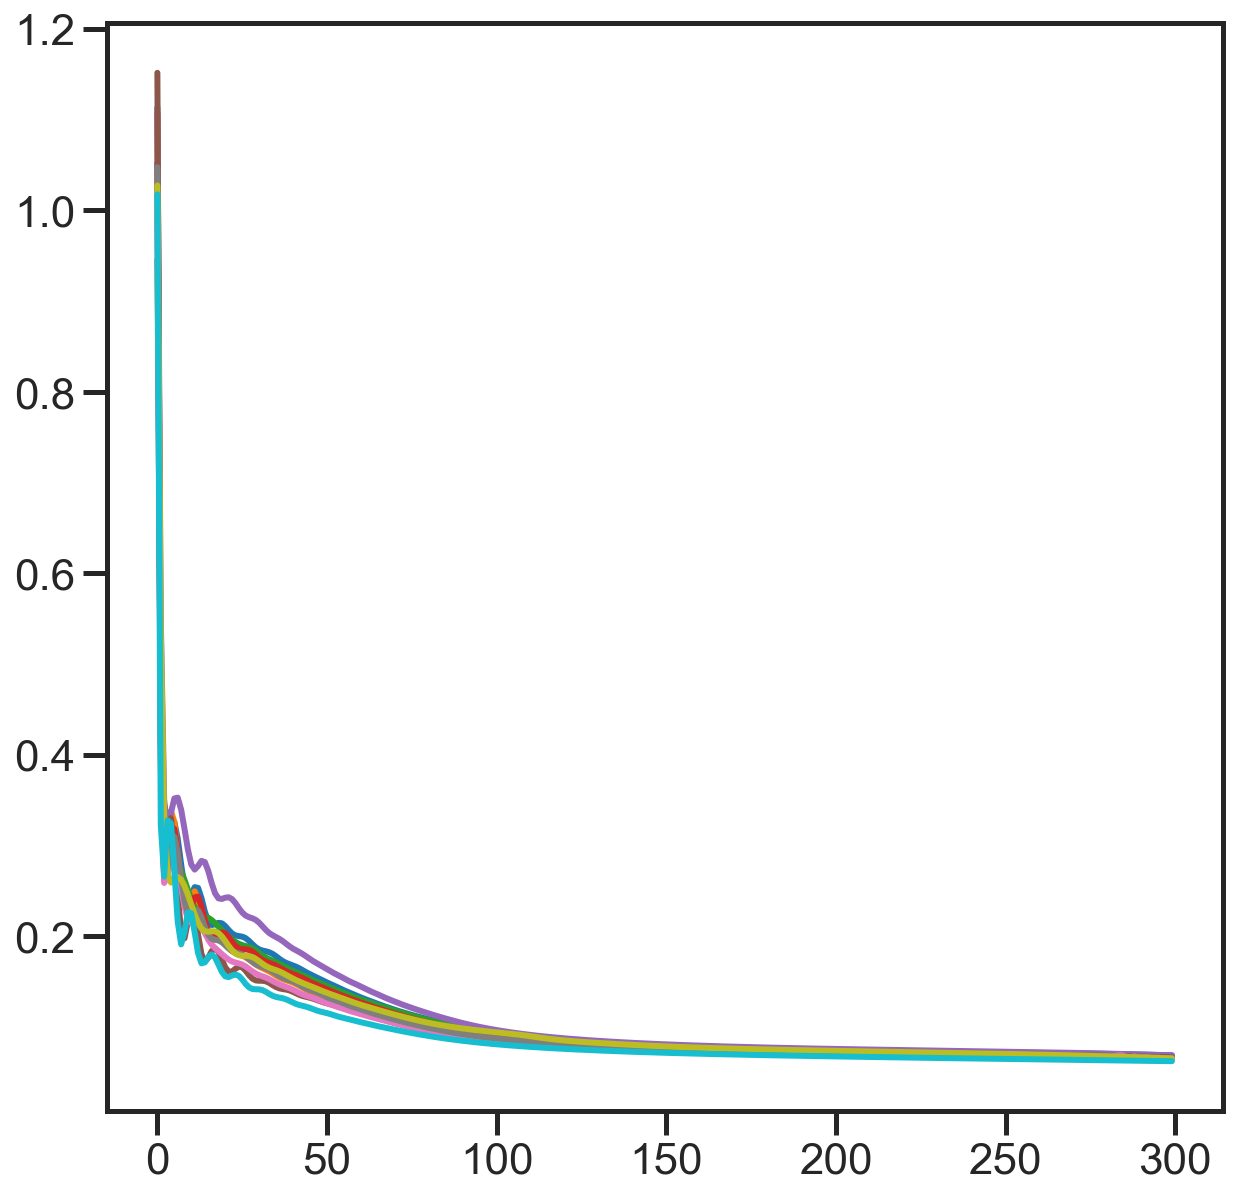

In [20]:
%%time

losses = []

for i in trange(epochs):
    losses.append( shuffle.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

C:\Users\thoma\Documents\GitHub\uncertainty_regression_pytorch\models\helpers.py:83: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)


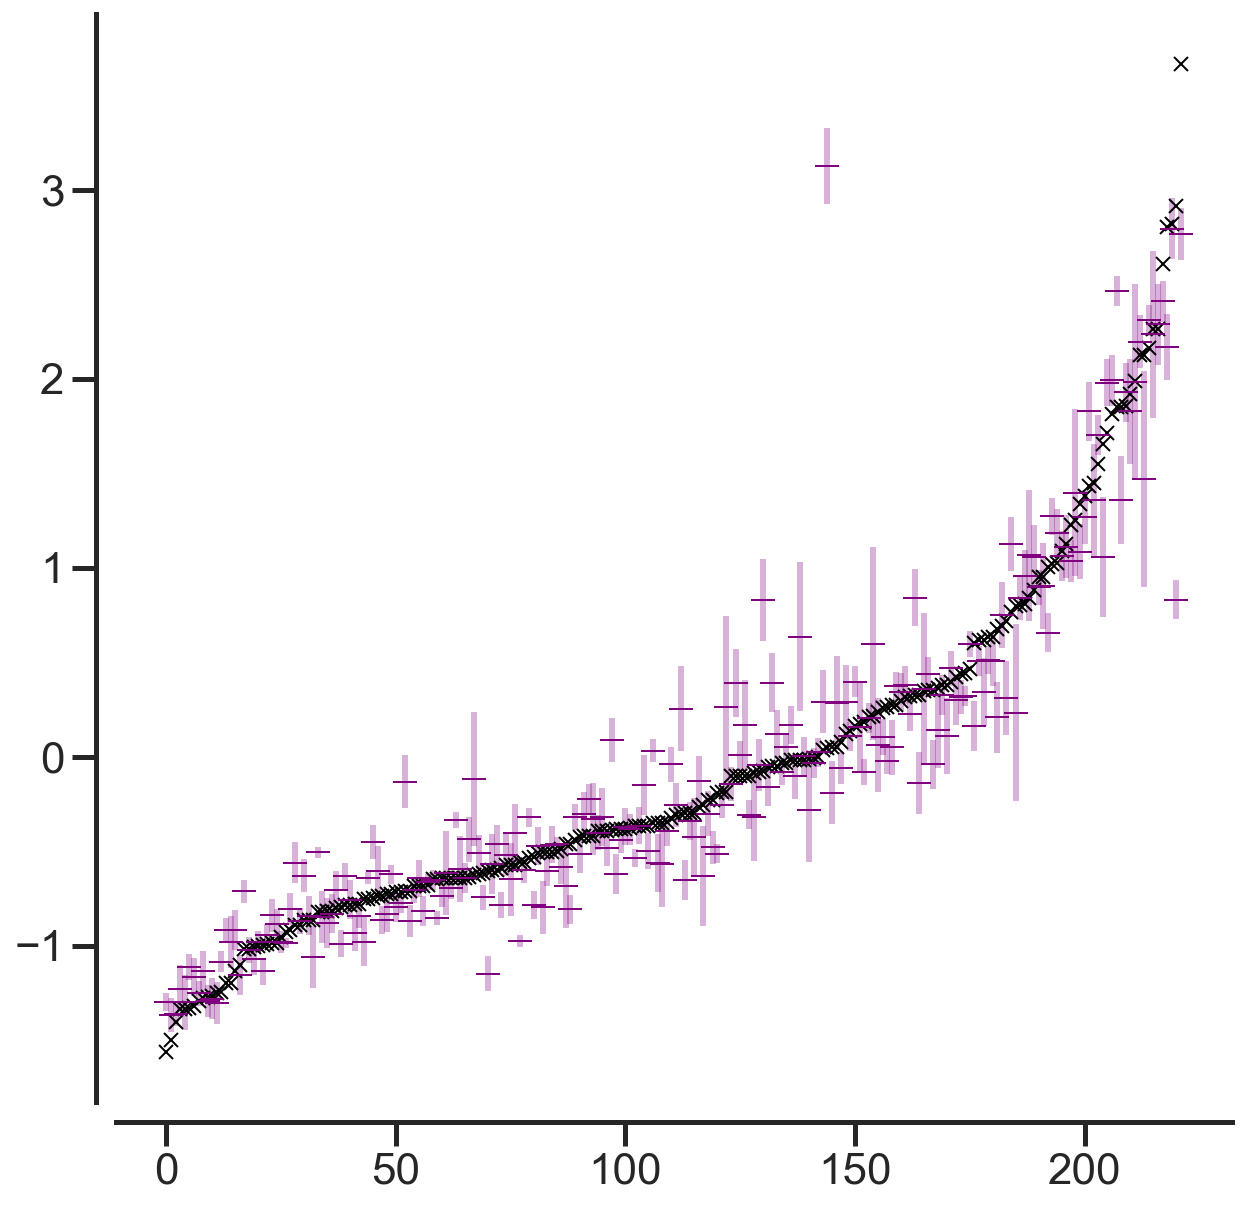

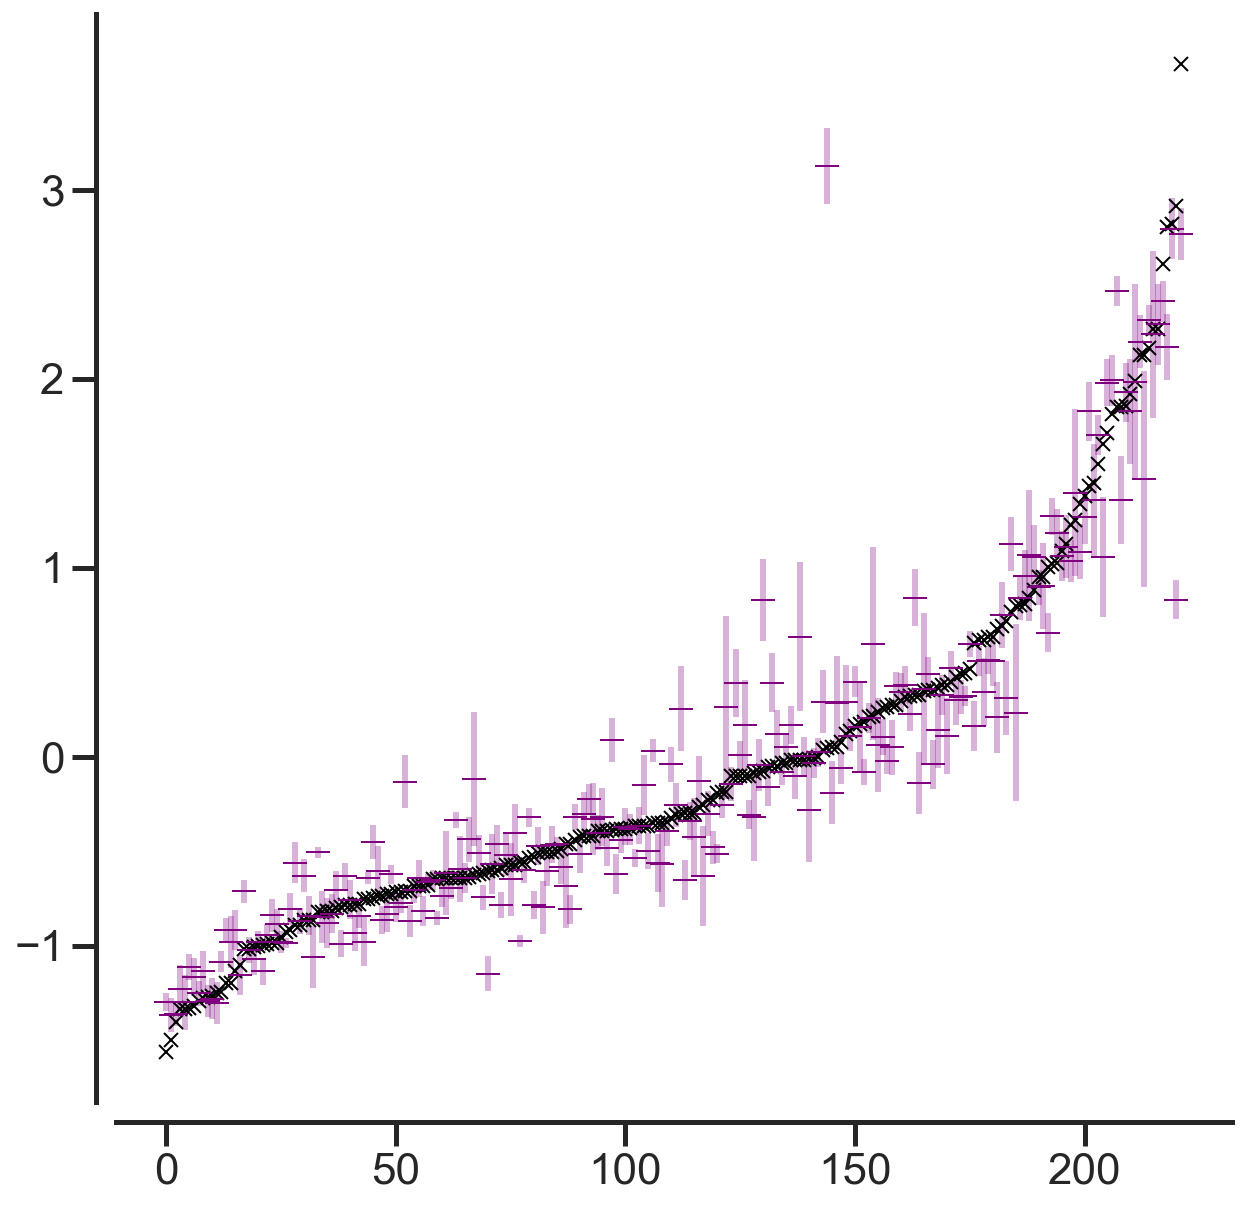

In [21]:
plot_uncertainty(shuffle,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('shuffle'))

In [22]:
from nn_models.ensembles import BootstrapEnsemble

showcase_code('nn_models/ensembles.py','BootstrapEnsemble')

In [23]:
bootstrap = BootstrapEnsemble(toy,output_dims,dataset_lenght = len(X_train),non_linearity=non_linearity)

In [24]:
bootstrap.models[0].non_linearity

torch.nn.modules.activation.Tanh

In [25]:
bootstrap.models[0].f

Sequential(
  (0): Linear(in_features=37, out_features=500, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=500, out_features=500, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=500, out_features=15, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.0, inplace=False)
  (9): Linear(in_features=15, out_features=1, bias=True)
)

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append(bootstrap.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [00:55<00:03,  4.29it/s]

In [ ]:
plot_uncertainty(bootstrap,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('bootstrap'))

In [ ]:
from nn_models.models import SaverModel

showcase_code('nn_models/models.py','SaverModel')


In [ ]:
saver = SaverModel(toy,output_dims,non_linearity=non_linearity,num_epochs_per_save = num_epochs_per_save)

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( saver.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(saver,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('saver'))

In [ ]:
from nn_models.models import BobstrapEnsemble

showcase_code('nn_models/models.py','BobstrapEnsemble')


In [ ]:
bob = BobstrapEnsemble(toy ,output_dims,num_epochs_per_save = num_epochs_per_save,non_linearity=non_linearity)

In [ ]:
bob.num_epochs_per_save

In [ ]:
%%time

losses = []

for i in trange(epochs):
    losses.append( bob.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(bob,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('bob'))

In [ ]:
from nn_models.models import DropoutModel

showcase_code('nn_models/models.py','DropoutModel')



In [ ]:
dropout = DropoutModel(toy,output_dims,p=0.05,non_linearity=non_linearity)

In [ ]:
plot_uncertainty(dropout,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('prior_dropout'))

In [ ]:
%%time

losses = []

for i in trange(epochs*2):
    losses.append( dropout.fit_model(X_train,y_train))
    
    
plt.plot(losses)
print(f'final loss: {losses[-1]}')

In [ ]:
plot_uncertainty(dropout,X_test,y_test,toy,all_predictions=all_predictions,fname=get_fig_path('dropout'))